In [62]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdMolDescriptors as rdescriptors

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

I chose Tyrosin kinase receptor FLT3. Not because it would be my favorite but because it was the first one I could find with a pleasant number of 5637 entries with IC50 values.

In [6]:
df = pd.read_csv('tyrosin_kinase_receptor_FLT3.csv', sep = ';')

At first, I loaded the data using pandas, I converted SMILES to molecule object using iteration through respective SMILES column. It worked nicely, no errors occured, smiles from each line were successfully converted.

In [13]:
molecules = [Chem.MolFromSmiles(smiles) for smiles in df['Smiles']]
len(df) == len(molecules)

True

I also loaded molecules from drugbank for comparison, there is 7115 of them.

In [15]:
suppl = Chem.SDMolSupplier('drugbank.sdf')
drugbank = [m for m in suppl if m]

## Descriptors

In [27]:
def lipinsky_ro5(molecules):
    lipinski = []
    for molecule in molecules:
        rules = [False, False, False, False]
        if Chem.Lipinski.NumHAcceptors(molecule) <= 10:
            rules[0] = True
        if Chem.Lipinski.NumHDonors(molecule) <= 5:
            rules[1] = True 
        if Descriptors.MolWt(molecule) < 500:
            rules[2] = True
        if Chem.Crippen.MolLogP(molecule) <= 5:
            rules[3] = True
        if rules.count(True) >= 3:
            lipinski.append(True)
        else:
            lipinski.append(False)
    return lipinski

In [51]:
rings = [Chem.GetSSSR(molecule) for molecule in molecules]
h_ac = [Chem.Lipinski.NumHAcceptors(molecule) for molecule in molecules]
h_don = [Chem.Lipinski.NumHDonors(molecule) for molecule in molecules]
mw = [Descriptors.MolWt(molecule) for molecule in molecules]
logp = [Chem.Crippen.MolLogP(molecule) for molecule in molecules]
lipinski = lipinsky_ro5(molecules)
mol_descriptors = {'Rings':rings, 'H_acceptors':h_ac, 'H_donors':h_don, 'MW':mw, 'LogP':logp, 'RO5':lipinski, 'Origin':['FLT3' for i in molecules]}

In [52]:
rings = [Chem.GetSSSR(molecule) for molecule in drugbank]
h_ac = [Chem.Lipinski.NumHAcceptors(molecule) for molecule in drugbank]
h_don = [Chem.Lipinski.NumHDonors(molecule) for molecule in drugbank]
mw = [Descriptors.MolWt(molecule) for molecule in drugbank]
logp = [Chem.Crippen.MolLogP(molecule) for molecule in drugbank]
lipinski = lipinsky_ro5(drugbank)
drugbank_descriptors = {'Rings':rings, 'H_acceptors':h_ac, 'H_donors':h_don, 'MW':mw, 'LogP':logp, 'RO5':lipinski, 'Origin':['Drugbank' for i in drugbank]}

In [57]:
mol_df = pd.DataFrame(mol_descriptors)
drugbank_df = pd.DataFrame(drugbank_descriptors)
df = pd.concat([mol_df, drugbank_df], axis = 0)

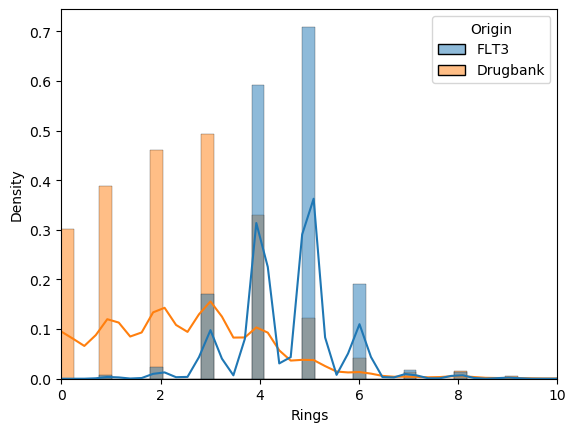

In [64]:
sns.histplot(data = df, x = 'Rings', hue = 'Origin', stat = 'density', kde = True)
plt.xlim(0, 10)
plt.show()